# Experimento 1: Palavras e temas dominantes


In [7]:
# Pacotes necessários
!pip install wordcloud nltk pandas matplotlib scikit-learn

# Importações padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
import string
from collections import Counter

# Para NLP
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Para o ambiente e os gráficos
from google.colab import drive
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
# Nessa célula estamos montando o drive e puxando o dataset

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Se for testar, substituir pelo seu caminho daa pasta das músicas
path_folder = '/content/drive/MyDrive/IFES/Disciplinas/6-periodo/Topicos-Especiais-de-Banco-de-Dados/Jogo-complete-a-letra/albuns_engenheiros_csv/musicas-analise'
all_files = glob.glob(os.path.join(path_folder, "*.csv"))
df_list = []
print(f"Encontrados {len(all_files)} arquivos na pasta.")


for filename in all_files:
    try:
        try:
            df_temp = pd.read_csv(filename, encoding='utf-8')
        except UnicodeDecodeError:
            df_temp = pd.read_csv(filename, encoding='latin-1')
        df_temp.columns = df_temp.columns.str.lower()

        if 'titulo' in df_temp.columns and 'letra' in df_temp.columns:
            df_temp['arquivo_origem'] = os.path.basename(filename)
            df_list.append(df_temp[['titulo', 'letra', 'arquivo_origem']])
        else:
            print(f"Aviso: {os.path.basename(filename)} ignorado (colunas incorretas).")
    except Exception as e:
        print(f"Erro ao ler {filename}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"\nSucesso! Total de músicas carregadas: {len(df)}")
else:
    print("Nenhum dado foi carregado. Caminho da pasta pode tá errado")

Encontrados 17 arquivos na pasta.

Sucesso! Total de músicas carregadas: 156


In [9]:
# Nessa célula fazemos o pré-processamento das músicas

def preprocessar(texto):
    if not isinstance(texto, str):
        return []

    # Converter para minúsculas
    texto = texto.lower()

    # Remover quebras de linha
    texto = texto.replace('\n', ' ').replace('\r', ' ')

    # Remover pontuação
    texto = texto.translate(str.maketrans('', '', string.punctuation))

    # Tokenização
    tokens = texto.split()

    # Remover Stopwords
    stops = set(stopwords.words('portuguese'))
    stops.update(['pra', 'pro', 'tá', 'tô', 'é', 'aí', 'então'])
    tokens = [word for word in tokens if word not in stops and len(word) > 2]
    return tokens

print("Pré-processamento feito")

Pré-processamento feito


Limpeza concluída.

--- TOP 10 PALAVRAS MAIS FREQUENTES ---
[('tudo', 246), ('nada', 195), ('sempre', 133), ('gente', 123), ('ninguém', 115), ('faz', 113), ('mundo', 104), ('dia', 104), ('vida', 97), ('nunca', 94)]


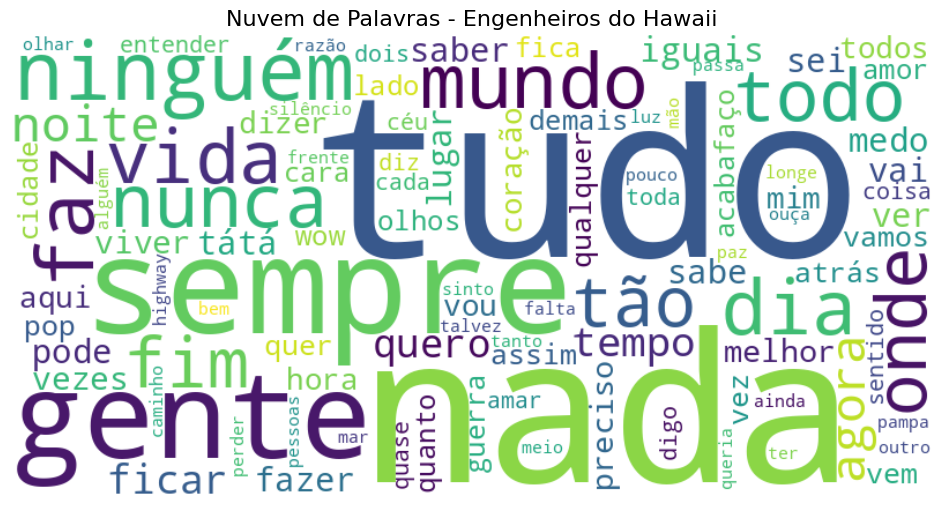

In [10]:
# Nessa célula, fazemos a contagem simples (top-10 termos e nuvem de palavras)

# Chamando a função de pré-processamento
if 'df' in locals() and not df.empty:
    df['tokens'] = df['letra'].apply(preprocessar)
    df['texto_limpo'] = df['tokens'].apply(lambda x: ' '.join(x))
    print("Limpeza concluída.")

    todos_tokens = [word for lista in df['tokens'] for word in lista]
    contagem = Counter(todos_tokens)

    # Mostra top 10 palavras
    print("\n--- TOP 10 PALAVRAS MAIS FREQUENTES ---")
    print(contagem.most_common(10))

    # Gerar o WordCloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis' # Cores modernas
    ).generate_from_frequencies(contagem)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nuvem de Palavras - Engenheiros do Hawaii", fontsize=16)
    plt.show()
else:
    print("Erro: O DataFrame 'df' está vazio ou não foi carregado. Rodar a Célula 2.")


--- TOP 20 TERMOS (SCORE TF-IDF) ---
Essas palavras têm peso estatístico alto no conjunto da obra:


/tmp/ipython-input-1494969737.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Termo', data=df_tfidf, palette='magma')


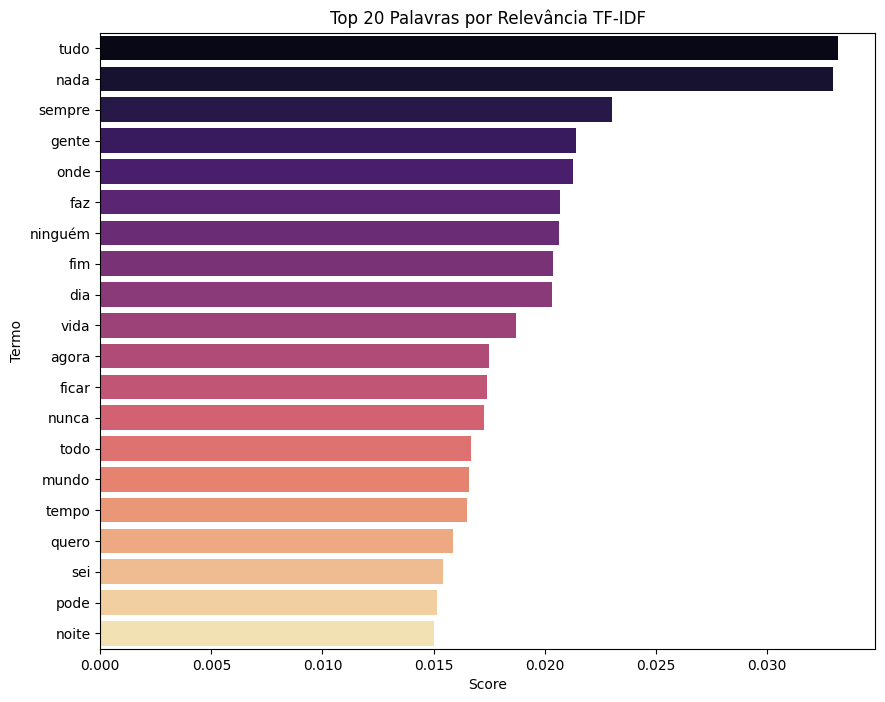

In [11]:
#Nessa célula produzimos o TF-IDF (Term Frequency-Inverse Document Frequency)

if 'df' in locals() and not df.empty:
    tfidf = TfidfVectorizer(stop_words=list(stopwords.words('portuguese')))

    matrix_tfidf = tfidf.fit_transform(df['texto_limpo'])
    feature_names = tfidf.get_feature_names_out()

    mean_tfidf = matrix_tfidf.mean(axis=0)

    tfidf_scores = [(feature_names[i], mean_tfidf[0, i]) for i in range(mean_tfidf.shape[1])]
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

    print("\n--- TOP 20 TERMOS (SCORE TF-IDF) ---")
    print("Essas palavras têm peso estatístico alto no conjunto da obra:")

    df_tfidf = pd.DataFrame(tfidf_scores[:20], columns=['Termo', 'Score'])

    # Mostrar gráfico
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Termo', data=df_tfidf, palette='magma')
    plt.title("Top 20 Palavras por Relevância TF-IDF")
    plt.show()

Análise e Reflexão (Resultados Qualitativos)

A análise dos dados revela que as músicas dos Engenheiros do Hawaii são marcadas por uma dualidade existencial, evidenciada pela predominância dos termos "Tudo" e "Nada" tanto na contagem simples quanto no TF-IDF. O vocabulário prioriza conceitos abstratos e temporais (como "Sempre", "Nunca", "Vida", "Mundo") em vez de expressões concretas, confirmando uma assinatura focada em reflexões filosóficas, na refletindo sobre a passagem do tempo e sobre a tensão entre o indivíduo e o coletivo.